# Анализ результатов А/В-теста мобильной игры жанра match-3

**Задача:** проанализировать, как на метриках проекта сказалось уменьшение скорости восстановления жизни с 30 до 3 минут. 

**Описание данных:** смоделированные данные пользователей за первых 7 дней жизни в игре.

**План проекта:**
* загрузить данные, сделать их предобработку и декомпозицию;
* проверить правильность распределения пользователей по группам;
* проанализировать прохождение пользователями уровней (старты, финиши и их виды) в контрольной и тестовой группах;
* проанализировать получение и траты золота в обеих группах;
* посмотреть на изменение метрик Retention rate, Churn rate, Conversion rate и LTV в группах;
* проверить гипотезы;
* сформулировать выводы об успешности проведения теста.

*Примечание:*

*В данных отсутствуют даты прихода в приложение и совершения действий, поэтому когорты будут определены только по принадлежности к контрольной или тестовой группе.*

*ID пользователей смоделированы таким образом, что ID одной группы полностью совпадают с ID другой группы, т.е. начинаются с 1 и т.д. Поэтому будем считать, что пользователей, которые попали в две группы, нет.*

*Считаем группу А - контрольной, а группу В - тестовой.*

*Ожидаемые метрики, на которые должны повлиять изменения и в какую сторону, определены не были, поэтому исходим из фактически полученных результатов.*

## Загрузка, предобработка и первичная проверка данных

In [55]:
# загружаем нужные библиотеки

import requests
from urllib.parse import urlencode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st

In [56]:
# получаем данные с Яндекс.Диска

# подготавливаем ссылки
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.by/i/ucbEk8NydnwLgw'

# получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)

# открываем файл
with open('Тестовое данные.xlsx', 'wb') as f:
    f.write(download_response.content)

# читаем файл и записываем в переменную
data = pd.read_excel('Тестовое данные.xlsx')

In [57]:
# приводим наименование колонок к нижнему регистру для удобства

data.columns = data.columns.str.lower()

In [58]:
# поскольку данные представляют только целые числа, то изменим тип с float на int

data.loc[:, data.columns != 'ab_cohort'] = (
    data.loc[:, data.columns != 'ab_cohort'].astype('int')
)

In [59]:
# создаем функцию для первичного обзора данных

def first_check(dataset):

    print('Первые 10 строк таблицы \n')
    display(dataset.head(10))

    print('-'*50)
    print('Последние 10 строк таблицы \n')
    display(dataset.tail(10))

    print('-'*50)
    print('Информация о таблице \n')   
    dataset.info()

    print('-'*50)
    print('Характеристики чисел в таблице \n')  
    display(dataset.describe())

    print('-'*50)
    print('Наименование колонок \n')  
    print(dataset.columns)
    
    print('-'*50)
    print('Количество дубликатов: {}\n'.format(dataset.duplicated().sum()))

In [60]:
first_check(data)

Первые 10 строк таблицы 



,retention,maxlevelpassed,user_id,ab_cohort,sumrevenue,countbuy,countallstart,countallfinish,countcleanstart,countcleanfinish,...,get_buy,get_faceb,get_teaml,get_teamt,spend_bonlives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_teamc
0,0,46,1,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,46,2,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,15,3,A,0,0,18,15,14,11,...,0,0,0,0,0,0,0,0,0,0
3,0,3,4,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,5,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,46,6,A,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,7,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,17,8,A,0,0,48,26,41,22,...,0,0,0,0,0,0,0,0,2970,0
8,0,0,9,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,8,9,A,0,0,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0


--------------------------------------------------
Последние 10 строк таблицы 



,retention,maxlevelpassed,user_id,ab_cohort,sumrevenue,countbuy,countallstart,countallfinish,countcleanstart,countcleanfinish,...,get_buy,get_faceb,get_teaml,get_teamt,spend_bonlives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_teamc
25372,5,34,4338,B,0,0,4,1,3,0,...,0,0,0,0,0,0,0,0,0,0
25373,6,37,4338,B,0,0,23,3,21,2,...,0,0,0,0,0,0,0,0,0,0
25374,7,39,4338,B,0,0,15,2,14,2,...,0,0,0,0,0,0,0,0,0,0
25375,0,2,4339,B,0,0,2,2,2,2,...,0,2000,0,0,0,0,0,0,0,0
25376,1,2,4339,B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25377,0,16,4340,B,76,1,23,19,17,14,...,2000,0,0,0,0,0,0,0,1980,0
25378,0,9,4341,B,0,0,13,9,9,7,...,0,0,0,0,0,0,0,0,2590,0
25379,1,22,4341,B,0,0,33,13,25,7,...,0,0,0,100,0,0,0,0,0,0
25380,2,25,4341,B,0,0,6,3,4,2,...,0,0,0,0,0,0,0,0,0,0
25381,4,27,4341,B,0,0,26,2,24,2,...,0,0,30,0,0,0,0,0,0,0


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25382 entries, 0 to 25381
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   retention         25382 non-null  int64 
 1   maxlevelpassed    25382 non-null  int64 
 2   user_id           25382 non-null  int64 
 3   ab_cohort         25382 non-null  object
 4   sumrevenue        25382 non-null  int64 
 5   countbuy          25382 non-null  int64 
 6   countallstart     25382 non-null  int64 
 7   countallfinish    25382 non-null  int64 
 8   countcleanstart   25382 non-null  int64 
 9   countcleanfinish  25382 non-null  int64 
 10  get_ads           25382 non-null  int64 
 11  get_chapter       25382 non-null  int64 
 12  get_buy           25382 non-null  int64 
 13  get_faceb         25382 non-null  int64 
 14  get_teaml         25382 non-null  int64 
 15  get_teamt         25382 non-nu

,retention,maxlevelpassed,user_id,sumrevenue,countbuy,countallstart,countallfinish,countcleanstart,countcleanfinish,get_ads,...,get_buy,get_faceb,get_teaml,get_teamt,spend_bonlives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_teamc
count,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,...,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000,25382.000000
mean,2.386219,39.703333,2064.276416,1.317548,0.006895,18.068277,5.402490,16.349775,4.485068,9.751005,...,24.741943,51.690174,2.039634,8.312978,0.039398,20.577575,2.694823,9.337326,319.953510,0.145773
std,2.372097,27.792685,1158.629383,35.967691,0.145834,24.925548,8.159008,23.459249,6.934723,29.995880,...,511.293483,317.352237,11.656315,27.622639,6.276783,221.838894,73.468143,125.347640,914.724713,3.917215
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,1120.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,36.000000,1982.000000,0.000000,0.000000,9.000000,2.000000,8.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,55.000000,2968.000000,0.000000,0.000000,23.000000,7.000000,21.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,365.000000,4348.000000,2508.000000,10.000000,382.000000,106.000000,368.000000,103.000000,200.000000,...,26500.000000,2000.000000,310.000000,200.000000,1000.000000,9600.000000,3800.000000,5000.000000,29390.000000,200.000000


--------------------------------------------------
Наименование колонок 

Index(['retention', 'maxlevelpassed', 'user_id', 'ab_cohort', 'sumrevenue',
       'countbuy', 'countallstart', 'countallfinish', 'countcleanstart',
       'countcleanfinish', 'get_ads', 'get_chapter', 'get_buy', 'get_faceb',
       'get_teaml', 'get_teamt', 'spend_bonlives', 'spend_bonus',
       'spend_boost', 'spend_lives', 'spend_moves', 'spend_teamc'],
      dtype='object')
--------------------------------------------------
Количество дубликатов: 0



In [61]:
# проверяем равномерность распределения пользователей по когортам

data.groupby('ab_cohort').agg({'user_id' : 'nunique'})

,user_id
ab_cohort,
A,4348
B,4341


In [62]:
# добавим колонку с обозначением времени на восстановление жизни

data['heart_time'] = np.where(data['ab_cohort'] == "A", 30, 3)

In [63]:
# поскольку данные о стартах и победах уровней представляют собой накопленные
# данные, создадим отдельную таблицу с количеством пройденных уровней

levels = (
    data.groupby(['user_id', 'ab_cohort'])
    .agg({
        'maxlevelpassed' : 'max',
        'countallstart' : 'max',
        'countallfinish' : 'max',
        'countcleanstart' : 'max',
        'countcleanfinish' : 'max',
        'heart_time' : 'max'})
    .reset_index()
)

# добавляем столбцы с количеством стартов и побед с применением бонусов
levels['notcleanstart'] = levels['countallstart'] - levels['countcleanstart']
levels['notcleanfinish'] = levels['countallfinish'] - levels['countcleanfinish']

levels.head() # смотрим результат

,user_id,ab_cohort,maxlevelpassed,countallstart,countallfinish,countcleanstart,countcleanfinish,heart_time,notcleanstart,notcleanfinish
0,1,A,46,0,0,0,0,30,0,0
1,1,B,55,72,38,63,30,3,9,8
2,2,A,46,0,0,0,0,30,0,0
3,2,B,45,90,39,79,32,3,11,7
4,3,A,15,18,15,14,11,30,4,4


In [64]:
# проверим, нет ли записей, в которых количество стартов равно нулю,
# а количество пройденных уровней больше нуля

print('Количество ошибочных записей:\n{}'.format(
    levels.loc[
        (levels['countallstart'] == 0) & (levels['maxlevelpassed'] != 0)
        ]['ab_cohort'].value_counts()
        )
)

print()

for group in list(levels['ab_cohort'].unique()):
    print('Процент ошибочных записей в группе {}: {:.2%}'.format(
        group,
        len(levels.loc[
            (levels['countallstart'] == 0)
            & (levels['maxlevelpassed'] != 0)
            & (levels['ab_cohort'] == group)])
        / len(levels.query('ab_cohort == @group'))
        )
    )

Количество ошибочных записей:
A    780
B    658
Name: ab_cohort, dtype: int64

Процент ошибочных записей в группе A: 17.94%
Процент ошибочных записей в группе B: 15.16%


In [65]:
# возможно, в записях ошибка;
# в данном случае замена на меданные значения может исказить реальные результаты,
# поэтому таких пользователей следует удалить;
# создаем список пользователей на удаление

users_for_delete = levels.loc[
    (levels['countallstart'] == 0) & (levels['maxlevelpassed'] != 0)
    ][['user_id', 'ab_cohort']]

# определяем пользователей, которые должны быть сохранены для анализа

levels = levels.merge(
    users_for_delete,
    how='left',
    left_on=['user_id', 'ab_cohort'],
    right_on=['user_id', 'ab_cohort'],
    indicator='i'
    )

# удаляем лишних пользователей и колонку с индикатором

levels = (
    levels.query('i == "left_only"').copy()
    .drop(columns='i').sort_values(by='ab_cohort')
)

# смотрим, сколько пользователей осталось в каждой группе

levels['ab_cohort'].value_counts()

B    3683
A    3568
Name: ab_cohort, dtype: int64

In [66]:
# проверяем, нет ли ошибки в записи данных, когда количество завершений
# уровней превышает количество стартов

print('Превышение всех побед над всеми стартами: {}'.format(len(
    levels.loc[levels['countallstart'] < levels['countallfinish']]
    )
))

print('Превышение чистых побед на чистыми стартами: {}'.format(len(
    levels.loc[levels['countcleanstart'] < levels['countcleanfinish']]
    )
))

print('Превышение побед с бонусами над стартами с бонусами: {}'.format(len(
    levels.loc[levels['notcleanstart'] < levels['notcleanfinish']]
    )
))

Превышение всех побед над всеми стартами: 0
Превышение чистых побед на чистыми стартами: 0
Превышение побед с бонусами над стартами с бонусами: 341


In [67]:
# заменим неверные данные о победах с бонусами на количество стартов с бонусами

levels['notcleanfinish'] = np.where(
    levels['notcleanstart'] < levels['notcleanfinish'],
    levels['notcleanstart'],
    levels['notcleanfinish']
    )

# проверяем

print('Превышение побед с бонусами над стартами с бонусами: {}'.format(len(
    levels.loc[levels['notcleanstart'] < levels['notcleanfinish']]
    )
))

Превышение побед с бонусами над стартами с бонусами: 0


In [68]:
# добавим колонки с долей стартов и побед с бонусами для каждого пользователя

levels['notcleanstart_percent'] = round(
    levels['notcleanstart'] / levels['countallstart'] * 100, 2).fillna(0)

levels['notcleanfinish_percent'] = round(
    levels['notcleanfinish'] / levels['countallfinish'] * 100, 2).fillna(0)

In [69]:
# создадим датасет для анализа получения и трат золота;
# поскольку данные о получении золота за прохождение уровней отсутствует,
# проверка превышения сумм трат над суммой получения не требуется

gold = (
    data.groupby(['user_id', 'ab_cohort'])
    .agg({
        'get_ads' : 'sum',
        'get_chapter' : 'sum',
        'get_buy' : 'sum',
        'get_faceb' : 'sum',
        'get_teaml' : 'sum',
        'get_teamt' : 'sum',
        'spend_bonlives' : 'sum',
        'spend_bonus' : 'sum',
        'spend_boost' : 'sum',
        'spend_lives' : 'sum',
        'spend_moves' : 'sum',
        'spend_teamc' : 'sum',
        'heart_time' : 'max'})
    .reset_index()
)

# определяем пользователей, которые должны быть сохранены для анализа

gold = gold.merge(
    users_for_delete,
    how='left',
    left_on=['user_id', 'ab_cohort'],
    right_on=['user_id', 'ab_cohort'],
    indicator='i'
    )

# удаляем лишних пользователей и колонку с индикатором

gold = (
    gold.query('i == "left_only"').copy()
    .drop(columns='i').sort_values(by='ab_cohort')
)

gold.head() #смотрим результат

,user_id,ab_cohort,get_ads,get_chapter,get_buy,get_faceb,get_teaml,get_teamt,spend_bonlives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_teamc,heart_time
4134,2068,A,0,340,0,0,0,0,0,0,0,0,0,0,30
4540,2271,A,0,0,0,0,0,0,0,0,0,0,990,0,30
4538,2270,A,0,0,0,0,0,0,0,0,0,0,0,0,30
4536,2269,A,0,0,0,0,0,0,0,0,0,0,0,0,30
4534,2268,A,0,0,0,0,0,0,0,0,0,0,0,0,30


In [70]:
# создаем датасет для анализа бизнес-показателей

profiles = data[['user_id', 'ab_cohort', 'retention', 'countbuy', 'sumrevenue']]

# определяем пользователей, которые должны быть сохранены для анализа

profiles = profiles.merge(
    users_for_delete,
    how='left',
    left_on=['user_id', 'ab_cohort'],
    right_on=['user_id', 'ab_cohort'],
    indicator='i'
    )

# удаляем лишних пользователей и колонку с индикатором

profiles = (
    profiles.query('i == "left_only"').copy()
    .drop(columns='i').sort_values(by='ab_cohort')
)

In [71]:
# определяем пользователей, совершивших покупки

payers = (
    profiles.groupby(['user_id', 'ab_cohort'])
    .agg({'countbuy' : 'max'})
    .query('countbuy != 0')
    .reset_index()[['user_id', 'ab_cohort']]
)

# добавляем информацию о платящих пользователях в таблицу с профайлами

profiles = profiles.merge(
    payers,
    how='left',
    left_on=['user_id', 'ab_cohort'],
    right_on=['user_id', 'ab_cohort'],
    indicator='i'
    )

profiles['payer'] = np.where(profiles['i'] == 'left_only', False, True)

profiles = profiles.drop(columns = 'i')

profiles.head() # смотрим результат

,user_id,ab_cohort,retention,countbuy,sumrevenue,payer
0,3,A,0,0,0,False
1,2503,A,7,0,0,False
2,2504,A,0,0,0,False
3,2504,A,1,0,0,False
4,2504,A,2,0,0,False


In [72]:
# проверим, нет ли ошибок в данных

print(
    'Количество записей, где количество покупок равно 0, а сумма покупок не равна нулю: {}'
    .format(len(profiles.query('countbuy == 0 & sumrevenue != 0')))
)

print(
    'Количество записей, где количество покупок не равно 0, а сумма покупок равна нулю: {}'
    .format(len(profiles.query('countbuy != 0 & sumrevenue == 0')))
)

Количество записей, где количество покупок равно 0, а сумма покупок не равна нулю: 0
Количество записей, где количество покупок не равно 0, а сумма покупок равна нулю: 0


**Итоги предобработки и проверки данных:**

* В данных отсутствую пропуски.

* В большинстве колонок множество нулей, в некоторых колонках есть выбросы. В таком случае лучше сравнивать медианные значения, например, в колонках с данными о прохождении уровней, или анализировать ненулевые значения отдельно от нулевых, как в колонках с тратами и получением золота.

* После удаления 1438 пользователей с ошибочными записями (16.5% от изначально количества) в группе А осталось 3568 пользователей, а в группе В - 3683. Соотношение групп пользователей составляет 49% / 51%, поэтому можно сделать вывод о том, что пользователи распределены равномерно между группами.

## Анализ прохождения уровней

In [73]:
# создаем функцию для анализа прохождения уровней в обеих группах

def boxplot(x_col, data=levels):

# выводим "ящик с усами" для каждой группы

    plt.figure(figsize=(15, 7))

    sns.boxplot(
        data=data,
        x=data[x_col],
        y=data['ab_cohort'],
        palette='gist_rainbow')

    plt.title('Распределение {} по группам'.format(x_col))

    plt.show()
    print()

# выводим максимальные, минимальные, средние и медианные значения для каждой группы

    for group in sorted(list(data['ab_cohort'].unique())):
        print('Показатели {} в группе {}'.format(x_col, group))
        print()
        print(
            data.loc[data['ab_cohort'] == group, x_col]
            .agg(['mean', 'median', 'min', 'max'])
            )
        print()

# выводим количество нулевых значений для каждой группы

        print('Количество нулевых значений колонки {} группы {}: {}'.format(
            x_col, group,
            len(data.loc[(data['ab_cohort'] == group) & (data[x_col] == 0)])
        ))
        
        print('Процент нулевых значений колонки {} группы {}: {:.2%}'.format(
            x_col, group, (
                len(data.loc[(data['ab_cohort'] == group) & (data[x_col] == 0)])
                / len(data.loc[data['ab_cohort'] == group])
                )
            )
        )
        print()

        print('_'*50)
        print()

# выводим процентную разницу медианных значений групп

    print('Процентное изменение медианных значений в {}: {:.2%}'.format(
        x_col, (
            (data.query('ab_cohort == "B"')[x_col].median()
            - data.query('ab_cohort == "A"')[x_col].median()
            ) / data.query('ab_cohort == "A"')[x_col].median()
        )
        )
    ) 

    print('*'*50)
    print() 

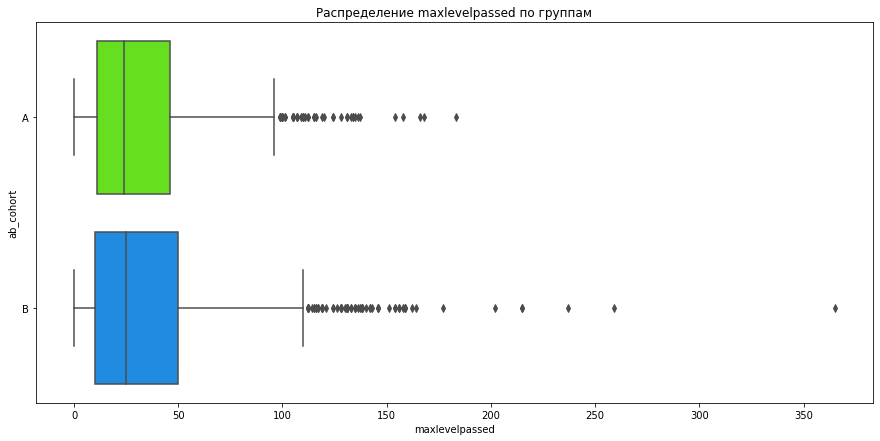


Показатели maxlevelpassed в группе A

mean       30.119675
median     24.000000
min         0.000000
max       183.000000
Name: maxlevelpassed, dtype: float64

Количество нулевых значений колонки maxlevelpassed группы A: 418
Процент нулевых значений колонки maxlevelpassed группы A: 11.72%

__________________________________________________

Показатели maxlevelpassed в группе B

mean       33.505566
median     25.000000
min         0.000000
max       365.000000
Name: maxlevelpassed, dtype: float64

Количество нулевых значений колонки maxlevelpassed группы B: 392
Процент нулевых значений колонки maxlevelpassed группы B: 10.64%

__________________________________________________

Процентное изменение медианных значений в maxlevelpassed: 4.17%
**************************************************



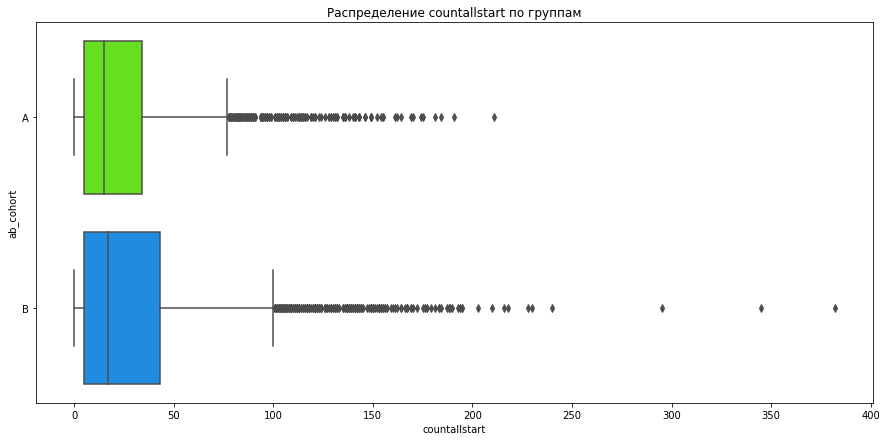


Показатели countallstart в группе A

mean       24.423487
median     15.000000
min         0.000000
max       211.000000
Name: countallstart, dtype: float64

Количество нулевых значений колонки countallstart группы A: 418
Процент нулевых значений колонки countallstart группы A: 11.72%

__________________________________________________

Показатели countallstart в группе B

mean       30.749661
median     17.000000
min         0.000000
max       382.000000
Name: countallstart, dtype: float64

Количество нулевых значений колонки countallstart группы B: 392
Процент нулевых значений колонки countallstart группы B: 10.64%

__________________________________________________

Процентное изменение медианных значений в countallstart: 13.33%
**************************************************



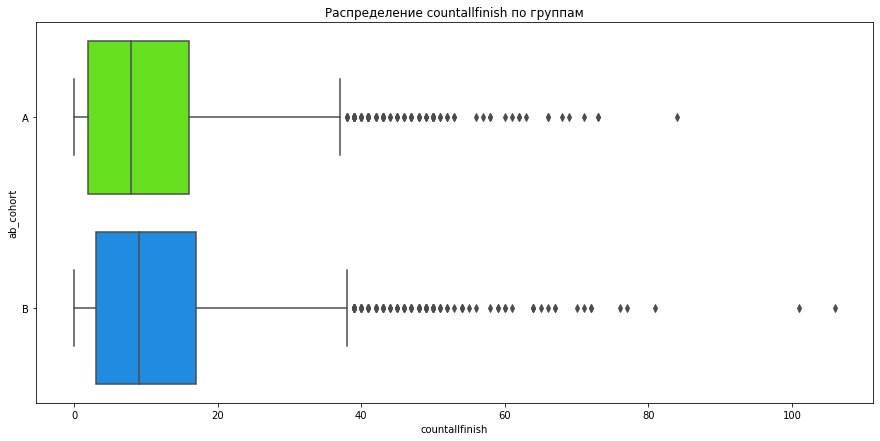


Показатели countallfinish в группе A

mean      10.828195
median     8.000000
min        0.000000
max       84.000000
Name: countallfinish, dtype: float64

Количество нулевых значений колонки countallfinish группы A: 594
Процент нулевых значений колонки countallfinish группы A: 16.65%

__________________________________________________

Показатели countallfinish в группе B

mean       11.797176
median      9.000000
min         0.000000
max       106.000000
Name: countallfinish, dtype: float64

Количество нулевых значений колонки countallfinish группы B: 545
Процент нулевых значений колонки countallfinish группы B: 14.80%

__________________________________________________

Процентное изменение медианных значений в countallfinish: 12.50%
**************************************************



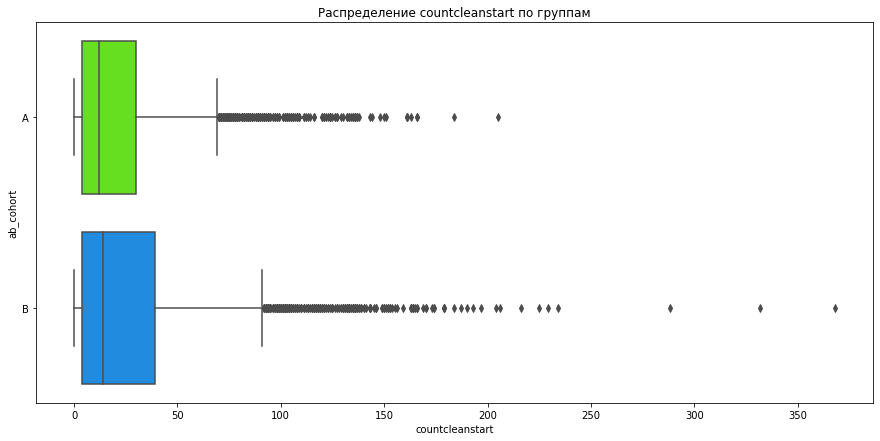


Показатели countcleanstart в группе A

mean       21.630045
median     12.000000
min         0.000000
max       205.000000
Name: countcleanstart, dtype: float64

Количество нулевых значений колонки countcleanstart группы A: 448
Процент нулевых значений колонки countcleanstart группы A: 12.56%

__________________________________________________

Показатели countcleanstart в группе B

mean       27.79256
median     14.00000
min         0.00000
max       368.00000
Name: countcleanstart, dtype: float64

Количество нулевых значений колонки countcleanstart группы B: 417
Процент нулевых значений колонки countcleanstart группы B: 11.32%

__________________________________________________

Процентное изменение медианных значений в countcleanstart: 16.67%
**************************************************



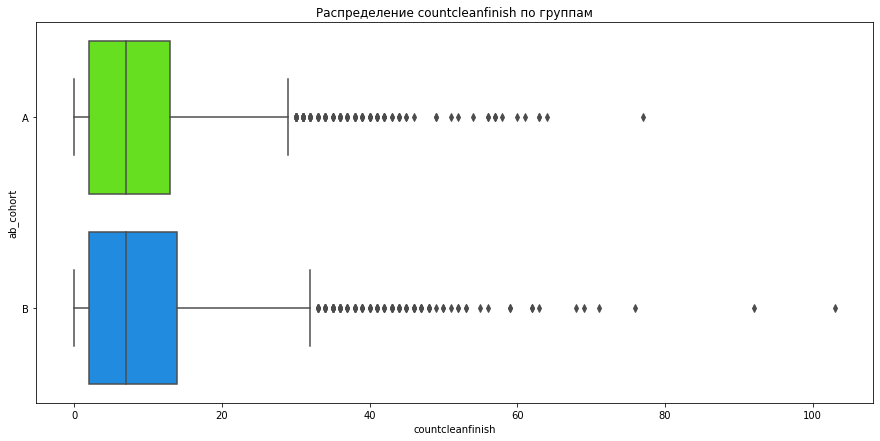


Показатели countcleanfinish в группе A

mean       8.904428
median     7.000000
min        0.000000
max       77.000000
Name: countcleanfinish, dtype: float64

Количество нулевых значений колонки countcleanfinish группы A: 622
Процент нулевых значений колонки countcleanfinish группы A: 17.43%

__________________________________________________

Показатели countcleanfinish в группе B

mean        9.76215
median      7.00000
min         0.00000
max       103.00000
Name: countcleanfinish, dtype: float64

Количество нулевых значений колонки countcleanfinish группы B: 575
Процент нулевых значений колонки countcleanfinish группы B: 15.61%

__________________________________________________

Процентное изменение медианных значений в countcleanfinish: 0.00%
**************************************************



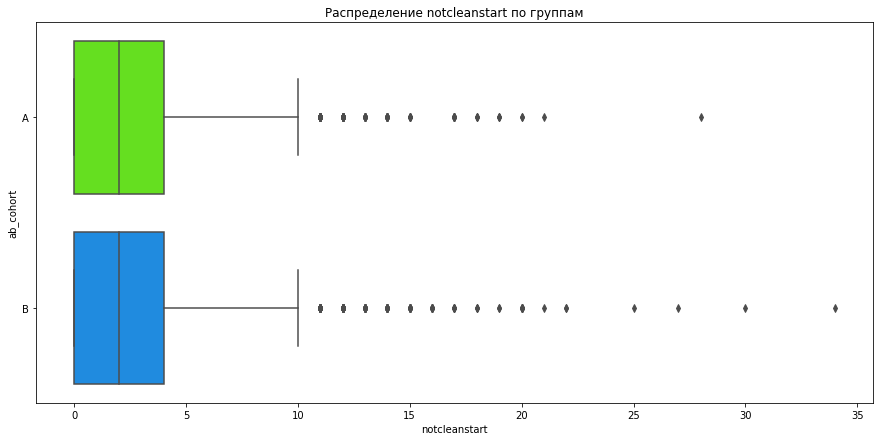


Показатели notcleanstart в группе A

mean       2.793442
median     2.000000
min        0.000000
max       28.000000
Name: notcleanstart, dtype: float64

Количество нулевых значений колонки notcleanstart группы A: 1079
Процент нулевых значений колонки notcleanstart группы A: 30.24%

__________________________________________________

Показатели notcleanstart в группе B

mean       2.9571
median     2.0000
min        0.0000
max       34.0000
Name: notcleanstart, dtype: float64

Количество нулевых значений колонки notcleanstart группы B: 999
Процент нулевых значений колонки notcleanstart группы B: 27.12%

__________________________________________________

Процентное изменение медианных значений в notcleanstart: 0.00%
**************************************************



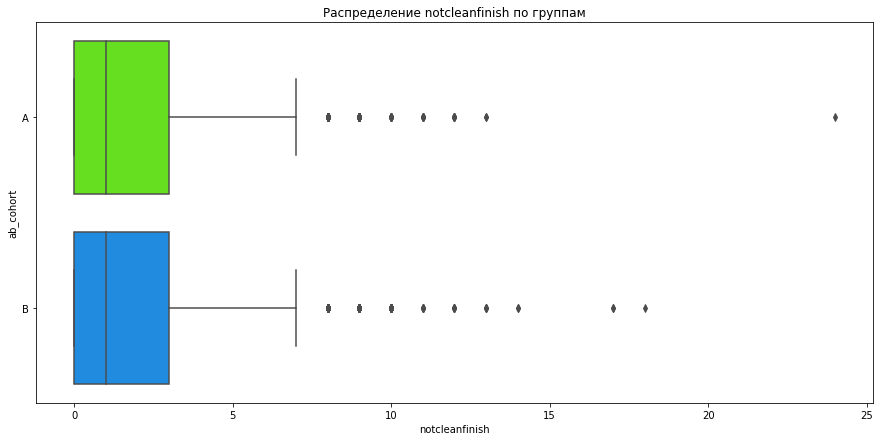


Показатели notcleanfinish в группе A

mean       1.840527
median     1.000000
min        0.000000
max       24.000000
Name: notcleanfinish, dtype: float64

Количество нулевых значений колонки notcleanfinish группы A: 1410
Процент нулевых значений колонки notcleanfinish группы A: 39.52%

__________________________________________________

Показатели notcleanfinish в группе B

mean       1.915829
median     1.000000
min        0.000000
max       18.000000
Name: notcleanfinish, dtype: float64

Количество нулевых значений колонки notcleanfinish группы B: 1329
Процент нулевых значений колонки notcleanfinish группы B: 36.08%

__________________________________________________

Процентное изменение медианных значений в notcleanfinish: 0.00%
**************************************************



In [74]:
# применяем функцию для всех данных со стартами и победами

for col in levels.loc[:,
                      (levels.columns != 'user_id')
                      & (levels.columns != 'ab_cohort')
                      & (levels.columns != 'heart_time')
                      & (levels.columns != 'notcleanstart_percent')
                      & (levels.columns != 'notcleanfinish_percent')
                      ].columns:
    boxplot(col)

In [75]:
# посмотрим, сколько требуется попыток для прохождения одного уровня
# в каждой группе;
# создадим для этого функцию

def start_finish(start_col, finish_col, data=levels):

    for group in list(data['ab_cohort'].unique()):

        df = data.query('ab_cohort == @group').copy()
        
        df['mean'] = df[start_col] / df[finish_col]

        print(
            'Медианное количество прохождений уровней до победы в группе {}: {}'
            .format(group, round(df['mean'].median(), 2))
        )

In [76]:
# применяем функцию ко всем стартам и победам

start_finish('countallstart', 'countallfinish')

Медианное количество прохождений уровней до победы в группе A: 1.89
Медианное количество прохождений уровней до победы в группе B: 1.93


In [77]:
# посмотрим, сколько требуется попыток для прохождения одного уровня
# без преимуществ в каждой группе

start_finish('countcleanstart', 'countcleanfinish')

Медианное количество прохождений уровней до победы в группе A: 2.0
Медианное количество прохождений уровней до победы в группе B: 2.0


In [78]:
# посмотрим, сколько требуется попыток для прохождения одного уровня
# без преимуществ в каждой группе

start_finish('notcleanstart', 'notcleanfinish')

Медианное количество прохождений уровней до победы в группе A: 1.33
Медианное количество прохождений уровней до победы в группе B: 1.33


In [79]:
# определяем средний процент стартов и побед с преимуществами для каждой группы
# только для тех пользователей, которые начали проходить хотя бы один уровень 

for group in list(levels['ab_cohort'].unique()):

    print(
        'Медианный процент стартов с преимуществами от общего числа стартов в группе {}: {}'
        .format(group, round(
            levels.query('countallstart != 0')
            ['notcleanstart_percent'].median(), 2
            ))
        )
    
    print(
        'Медианный процент побед с преимуществами от общего числа побед в группе {}: {}'
        .format(group, round(
            levels.query('countallstart != 0')
            ['notcleanfinish_percent'].median(), 2
            ))
    )
        
    print()

Медианный процент стартов с преимуществами от общего числа стартов в группе A: 11.11
Медианный процент побед с преимуществами от общего числа побед в группе A: 14.29

Медианный процент стартов с преимуществами от общего числа стартов в группе B: 11.11
Медианный процент побед с преимуществами от общего числа побед в группе B: 14.29



In [80]:
# посмотрим, коррелирует ли время восстановления жизни
# с показателями прохождения уровней

levels.corr()

,user_id,maxlevelpassed,countallstart,countallfinish,countcleanstart,countcleanfinish,heart_time,notcleanstart,notcleanfinish,notcleanstart_percent,notcleanfinish_percent
user_id,1.000000,-0.110618,-0.011976,0.094488,-0.021377,0.081084,0.002977,0.082404,0.122568,0.056422,0.051127
maxlevelpassed,-0.110618,1.000000,0.666390,0.423230,0.672513,0.453248,-0.059672,0.316711,0.159980,-0.111944,-0.021998
countallstart,-0.011976,0.666390,1.000000,0.781556,0.996410,0.804019,-0.095739,0.596415,0.454428,-0.116596,0.033927
countallfinish,0.094488,0.423230,0.781556,1.000000,0.750674,0.987785,-0.042700,0.732340,0.751694,0.082260,0.206831
countcleanstart,-0.021377,0.672513,0.996410,0.750674,1.000000,0.782509,-0.098793,0.526323,0.388853,-0.162188,-0.011878
countcleanfinish,0.081084,0.453248,0.804019,0.987785,0.782509,1.000000,-0.044443,0.656110,0.646580,0.009281,0.112170
heart_time,0.002977,-0.059672,-0.095739,-0.042700,-0.098793,-0.044443,1.000000,-0.024877,-0.016438,0.008810,-0.007542
notcleanstart,0.082404,0.316711,0.596415,0.732340,0.526323,0.656110,-0.024877,1.000000,0.877324,0.366722,0.453389
notcleanfinish,0.122568,0.159980,0.454428,0.751694,0.388853,0.646580,-0.016438,0.877324,1.000000,0.393044,0.567357
notcleanstart_percent,0.056422,-0.111944,-0.116596,0.082260,-0.162188,0.009281,0.008810,0.366722,0.393044,1.000000,0.749415


**Итоги анализа прохождения уровней:**

1. В группе А пользователи максимально доходили до 24 уровня, а в группе В - до 25. Иными словами, в тестовой группе медианное значение на 4% больше относительно контрольной группы. При этом доля пользователей, не проходивших ни одного уровня, отличается лишь на 1 процентный пункт: 11.7% в группе А и 10.6% в группе В.

2. Медианное количество:

  * всех стартов в группе А составило 15, а в группе В - 17, разница показателя тестовой группы по отношению к контрольной составляет 13.3%.

  * чистых стартов в группе А равно 12, а в группе В - 14. Показатели отличаются на 16.7%. Доля пользователей, не стартовавших без бонусов в контрольной группе составляет 12.5%, а в группе В - 11.3%.

  * стартов с бонусом в обеих группах равно 2, доля тех, кто ни разу не стартовал с бонусом в контрольной группе равно 30.2%, а в тестовой группе - 27.1%.

  * всех побед в группе А составило 8, а в группе В - 9, разница показателей составляет 12.5%. Доля пользователей не завершивших ни одного уровня победой в группе А составила - 16.6%, а в группе В - 14.8%.

  * чистых побед на пользователя в группе А и в группе В равно 7. При этом доля пользователей, не завершивших успешно ни один уровень, в группе А составляет 17.4%, а в группе В - 15.6%.

  * побед с бонусами одинаково в обеих группах - 1. Доля пользователей, не завершивших ни одного уровня с бонусами в группе А составила 39.5%, в группе В - 36%.

3. И в контрольной, и в тестовой группах медианное количество попыток для прохождения уровня не отличается и составляет:
  * для всех уровней - 1.9;
  * для чистых уровней - 2;
  * для уровней с бонусами - 1.3.

4. Доля стартов и побед с преимуществами от общего числа стартов и побед пользователей, которые начали прохождение хотя бы одного уровня в группах не отличается, и составляет 11.1% и 14.3% соответственно.

5. Корреляционная матрица показала, что время восстановления жизни не коррелирует с каким-либо показателем прохождения уровня.

Таким образом, уменьшение времени восстановления жизни способствует небольшому увеличению количества прохождений уровней как удачных, так и неудачных.

## Анализ получения и трат золота

In [81]:
# создаем функцию для анализа получения и трат золота в обеих группах

def histplot(x_col, data=gold, hist=False, bins=10):

# выводим максимальные, минимальные, средние и медианные значения для каждой группы
# без нулевых значений

    for group in list(data['ab_cohort'].unique()):
        print(
            'Показатели {} без нулевых значений в группе {}'
            .format(x_col, group)
            )
        print()
        print(data.loc[
            (data['ab_cohort'] == group) & (data[x_col] != 0), x_col]
            .agg(['mean', 'median', 'min', 'max']))
        print()

# выводим количество нулевых значений для каждой группы

        print('Количество нулевых значений колонки {} группы {}: {}'.format(
            x_col, group,
            len(data.loc[(data['ab_cohort'] == group) & (data[x_col] == 0)])
        ))
        
        print('Процент нулевых значений колонки {} группы {}: {:.2%}'.format(
            x_col, group, (
                len(data.loc[(data['ab_cohort'] == group) & (data[x_col] == 0)])
                / len(data.loc[data['ab_cohort'] == group])
                )
            )
        )
        print()

        print('_'*50)
        print()

# выводим процентную разницу медианных значений групп без нулевых значений

    print(
        'Процентное изменение медианных значений без нулевых значений в {}: {:.2%}'
        .format(x_col, (
            data.loc[
                (data['ab_cohort'] == "B") & (data[x_col] != 0), x_col
                ].median()
            - data.loc[
                (data['ab_cohort'] == "A") & (data[x_col] != 0), x_col
                ].median()
            ) / data.loc[
                (data['ab_cohort'] == "A") & (data[x_col] != 0), x_col
                ].median()
                )
        )
    
    print()

    if hist == True:

    # выводим графики распределения для каждой группы

        plt.figure(figsize=(15, 5))

        ax1 = plt.subplot(1, 2, 1)
        sns.histplot(data=data.query('ab_cohort == "A"')[x_col], bins=bins,
                    color=sns.color_palette('gist_rainbow')[-4])
        plt.title('Распределение {} в группе А'.format(x_col))
        plt.xlabel('Сумма {}'.format(x_col))
        plt.ylabel('Количество пользователей')

        ax2 = plt.subplot(1, 2, 2, sharey=ax1)
        sns.histplot(data=data.query('ab_cohort == "B"')[x_col], bins=bins,
                    color=sns.color_palette('gist_rainbow')[-2])
        plt.title('Распределение {} в группе В'.format(x_col))
        plt.xlabel('Суммарное {}'.format(x_col))
        plt.ylabel('Количество пользователей')

Показатели get_ads без нулевых значений в группе A

mean      249.892009
median    200.000000
min       100.000000
max       800.000000
Name: get_ads, dtype: float64

Количество нулевых значений колонки get_ads группы A: 3105
Процент нулевых значений колонки get_ads группы A: 87.02%

__________________________________________________

Показатели get_ads без нулевых значений в группе B

mean       253.949904
median     200.000000
min        100.000000
max       1000.000000
Name: get_ads, dtype: float64

Количество нулевых значений колонки get_ads группы B: 3164
Процент нулевых значений колонки get_ads группы B: 85.91%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_ads: 0.00%



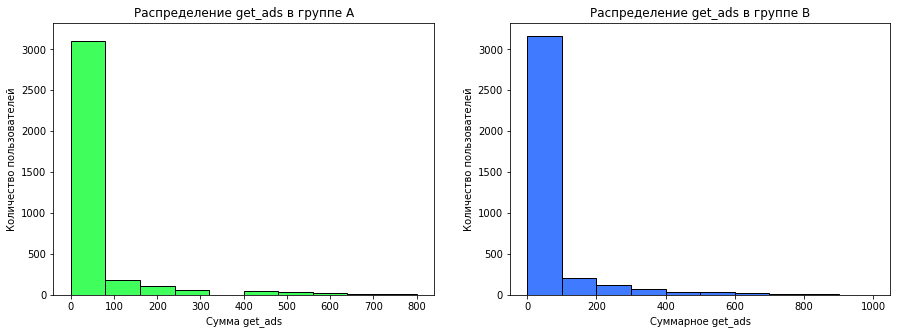

In [82]:
# применяем функцию для получения золота за просмотр рекламы
histplot('get_ads', hist=True)

Показатели get_chapter без нулевых значений в группе A

mean       358.961814
median     340.000000
min        100.000000
max       1540.000000
Name: get_chapter, dtype: float64

Количество нулевых значений колонки get_chapter группы A: 2730
Процент нулевых значений колонки get_chapter группы A: 76.51%

__________________________________________________

Показатели get_chapter без нулевых значений в группе B

mean       390.303337
median     360.000000
min        100.000000
max       1810.000000
Name: get_chapter, dtype: float64

Количество нулевых значений колонки get_chapter группы B: 2694
Процент нулевых значений колонки get_chapter группы B: 73.15%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_chapter: 5.88%



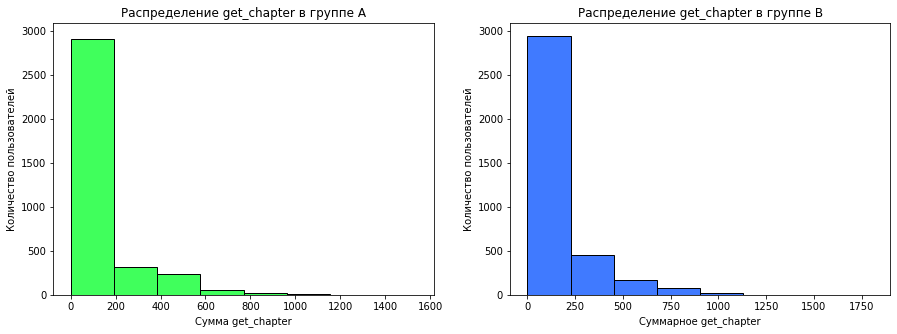

In [83]:
# применяем функцию для получения золота за прохождение глав
histplot('get_chapter', bins=8, hist=True)

In [84]:
# применяем функцию для получения золота из покупки
histplot('get_buy')

Показатели get_buy без нулевых значений в группе A

mean       8535.9375
median     4700.0000
min        1000.0000
max       59800.0000
Name: get_buy, dtype: float64

Количество нулевых значений колонки get_buy группы A: 3536
Процент нулевых значений колонки get_buy группы A: 99.10%

__________________________________________________

Показатели get_buy без нулевых значений в группе B

mean      10336.764706
median    10000.000000
min        1000.000000
max       32000.000000
Name: get_buy, dtype: float64

Количество нулевых значений колонки get_buy группы B: 3649
Процент нулевых значений колонки get_buy группы B: 99.08%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_buy: 112.77%



In [85]:
# применяем функцию для получения золота за логин в Facebook
histplot('get_faceb')

Показатели get_faceb без нулевых значений в группе A

mean      2000.0
median    2000.0
min       2000.0
max       2000.0
Name: get_faceb, dtype: float64

Количество нулевых значений колонки get_faceb группы A: 3248
Процент нулевых значений колонки get_faceb группы A: 91.03%

__________________________________________________

Показатели get_faceb без нулевых значений в группе B

mean      2000.0
median    2000.0
min       2000.0
max       2000.0
Name: get_faceb, dtype: float64

Количество нулевых значений колонки get_faceb группы B: 3347
Процент нулевых значений колонки get_faceb группы B: 90.88%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_faceb: 0.00%



Показатели get_teaml без нулевых значений в группе A

mean      105.782313
median     60.000000
min        10.000000
max       840.000000
Name: get_teaml, dtype: float64

Количество нулевых значений колонки get_teaml группы A: 3274
Процент нулевых значений колонки get_teaml группы A: 91.76%

__________________________________________________

Показатели get_teaml без нулевых значений в группе B

mean       88.540773
median     60.000000
min        10.000000
max       390.000000
Name: get_teaml, dtype: float64

Количество нулевых значений колонки get_teaml группы B: 3450
Процент нулевых значений колонки get_teaml группы B: 93.67%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_teaml: 0.00%



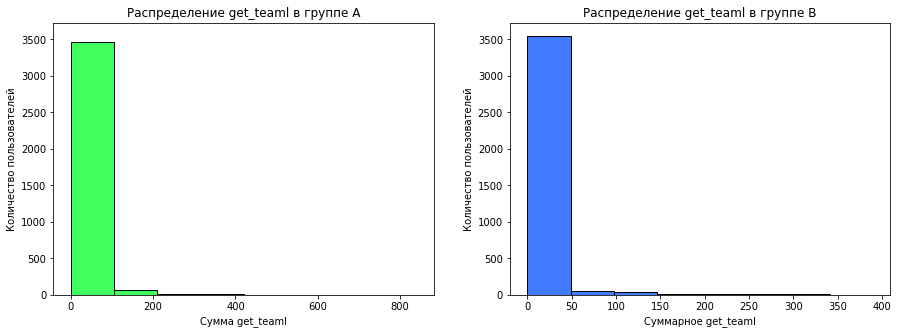

In [86]:
# применяем функцию для получения золота за отправку жизней в команде
histplot('get_teaml', bins=8, hist=True)

In [87]:
# применяем функцию для получения золота за прохождение туториала для команды
histplot('get_teamt')

Показатели get_teamt без нулевых значений в группе A

mean      100.0
median    100.0
min       100.0
max       100.0
Name: get_teamt, dtype: float64

Количество нулевых значений колонки get_teamt группы A: 2537
Процент нулевых значений колонки get_teamt группы A: 71.10%

__________________________________________________

Показатели get_teamt без нулевых значений в группе B

mean      100.27907
median    100.00000
min       100.00000
max       200.00000
Name: get_teamt, dtype: float64

Количество нулевых значений колонки get_teamt группы B: 2608
Процент нулевых значений колонки get_teamt группы B: 70.81%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в get_teamt: 0.00%



In [88]:
# применяем функцию для трат золота на покупку жизней для бонусных глав
histplot('spend_bonlives')

Показатели spend_bonlives без нулевых значений в группе A

mean      1000.0
median    1000.0
min       1000.0
max       1000.0
Name: spend_bonlives, dtype: float64

Количество нулевых значений колонки spend_bonlives группы A: 3567
Процент нулевых значений колонки spend_bonlives группы A: 99.97%

__________________________________________________

Показатели spend_bonlives без нулевых значений в группе B

mean     NaN
median   NaN
min      NaN
max      NaN
Name: spend_bonlives, dtype: float64

Количество нулевых значений колонки spend_bonlives группы B: 3683
Процент нулевых значений колонки spend_bonlives группы B: 100.00%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_bonlives: nan%



In [89]:
# применяем функцию для трат золота на покупку бонусов
histplot('spend_bonus')

Показатели spend_bonus без нулевых значений в группе A

mean      1689.51049
median    1400.00000
min        900.00000
max       9100.00000
Name: spend_bonus, dtype: float64

Количество нулевых значений колонки spend_bonus группы A: 3425
Процент нулевых значений колонки spend_bonus группы A: 95.99%

__________________________________________________

Показатели spend_bonus без нулевых значений в группе B

mean       1935.862069
median      900.000000
min         900.000000
max       23400.000000
Name: spend_bonus, dtype: float64

Количество нулевых значений колонки spend_bonus группы B: 3538
Процент нулевых значений колонки spend_bonus группы B: 96.06%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_bonus: -35.71%



In [90]:
# применяем функцию для трат золота на покупку бустеров
histplot('spend_boost')

Показатели spend_boost без нулевых значений в группе A

mean      2216.666667
median    1900.000000
min       1900.000000
max       3800.000000
Name: spend_boost, dtype: float64

Количество нулевых значений колонки spend_boost группы A: 3556
Процент нулевых значений колонки spend_boost группы A: 99.66%

__________________________________________________

Показатели spend_boost без нулевых значений в группе B

mean      1990.47619
median    1900.00000
min       1900.00000
max       3800.00000
Name: spend_boost, dtype: float64

Количество нулевых значений колонки spend_boost группы B: 3662
Процент нулевых значений колонки spend_boost группы B: 99.43%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_boost: 0.00%



In [91]:
# применяем функцию для трат золота на покупку жизней
histplot('spend_lives')

Показатели spend_lives без нулевых значений в группе A

mean      1534.883721
median    1000.000000
min       1000.000000
max       6000.000000
Name: spend_lives, dtype: float64

Количество нулевых значений колонки spend_lives группы A: 3439
Процент нулевых значений колонки spend_lives группы A: 96.38%

__________________________________________________

Показатели spend_lives без нулевых значений в группе B

mean      1444.444444
median    1000.000000
min       1000.000000
max       3000.000000
Name: spend_lives, dtype: float64

Количество нулевых значений колонки spend_lives группы B: 3656
Процент нулевых значений колонки spend_lives группы B: 99.27%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_lives: 0.00%



In [92]:
# применяем функцию для трат золота на покупку ходов
histplot('spend_moves')

Показатели spend_moves без нулевых значений в группе A

mean       2630.089532
median     2590.000000
min         990.000000
max       56020.000000
Name: spend_moves, dtype: float64

Количество нулевых значений колонки spend_moves группы A: 2116
Процент нулевых значений колонки spend_moves группы A: 59.30%

__________________________________________________

Показатели spend_moves без нулевых значений в группе B

mean       2676.70412
median     2590.00000
min         990.00000
max       26580.00000
Name: spend_moves, dtype: float64

Количество нулевых значений колонки spend_moves группы B: 2081
Процент нулевых значений колонки spend_moves группы B: 56.50%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_moves: 0.00%



In [93]:
# применяем функцию для трат золота на создание команды
histplot('spend_teamc')

Показатели spend_teamc без нулевых значений в группе A

mean      105.0
median    100.0
min       100.0
max       200.0
Name: spend_teamc, dtype: float64

Количество нулевых значений колонки spend_teamc группы A: 3548
Процент нулевых значений колонки spend_teamc группы A: 99.44%

__________________________________________________

Показатели spend_teamc без нулевых значений в группе B

mean      100.0
median    100.0
min       100.0
max       100.0
Name: spend_teamc, dtype: float64

Количество нулевых значений колонки spend_teamc группы B: 3667
Процент нулевых значений колонки spend_teamc группы B: 99.57%

__________________________________________________

Процентное изменение медианных значений без нулевых значений в spend_teamc: 0.00%



In [94]:
# посмотрим, коррелирует ли время восстановления жизни
# с показателями получения и трат золота

gold.corr()

,user_id,get_ads,get_chapter,get_buy,get_faceb,get_teaml,get_teamt,spend_bonlives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_teamc,heart_time
user_id,1.000000,0.135193,-0.019030,0.004975,0.117083,0.025159,0.100599,0.002612,0.020734,0.023084,0.043492,0.088047,0.036493,0.002977
get_ads,0.135193,1.000000,0.417846,0.020328,0.279785,0.367677,0.483712,-0.003702,0.100941,0.016289,0.218308,0.337399,0.078992,-0.015510
get_chapter,-0.019030,0.417846,1.000000,0.093827,0.096872,0.313013,0.319912,0.011173,0.110875,0.019301,0.164346,0.281149,0.059188,-0.052624
get_buy,0.004975,0.020328,0.093827,1.000000,0.027662,0.018924,0.041122,-0.000752,0.401657,0.217759,0.064594,0.582100,0.016544,-0.007009
get_faceb,0.117083,0.279785,0.096872,0.027662,1.000000,0.153401,0.219959,-0.003704,0.106067,0.030026,0.132175,0.325061,0.135717,-0.002691
get_teaml,0.025159,0.367677,0.313013,0.018924,0.153401,1.000000,0.183628,-0.002220,0.096384,0.023252,0.162869,0.158840,0.045761,0.041269
get_teamt,0.100599,0.483712,0.319912,0.041122,0.219959,0.183628,1.000000,-0.007506,0.076709,0.030045,0.161919,0.459519,0.104546,-0.004107
spend_bonlives,0.002612,-0.003702,0.011173,-0.000752,-0.003704,-0.002220,-0.007506,1.000000,-0.001604,-0.000768,-0.001475,-0.007140,-0.000819,0.011932
spend_bonus,0.020734,0.100941,0.110875,0.401657,0.106067,0.096384,0.076709,-0.001604,1.000000,0.045132,0.098388,0.160204,0.006916,-0.008060
spend_boost,0.023084,0.016289,0.019301,0.217759,0.030026,0.023252,0.030045,-0.000768,0.045132,1.000000,-0.001233,0.125705,0.020262,-0.013492


**Итоги анализа получения и трат золота:**

Медианное суммарное значение:
1. получения золота:
* за просмотр рекламы остался на уровне 200 в обеих группах. Процент нулевых значений в группе А составляет 87%, а в группе В - 86%.
* за прохождение глав в контрольной группе составляет 340, в тестовой - 360. Доля пользователей, не прошедших ни одну главу, в группе А составляет 76.5%, а в группе В - 73%.
* из покупки не сопоставимо, поскольку покупку золота в обеих группах совершил лишь 1% пользователей.
* за логин в Facebook не изменилось, поскольку является разовым и фиксированным. Доля пользователей, получивших золото таким образом, в группах также не отличается и составляет 9%.
* за отправку жизней в команде в группах не изменилось и составило 60. В тестовой группе жизни отправляло меньшее количество пользователей - 6.3%, чем в контрольной группе - 8.2%.
* за прохождение туториала для команды не отличается и равно 100 (возможно, за неделю жизни была возможность пройти только один туториал), как и не отличается процент тех, кто туториал не завершил - 71% в обеих группах.

2. трат золота:
* на покупку жизней для бонусных глав не сравнимы, поскольку в группе В никто их не приобретал, а в группе А - только один пользователь.
* на покупку бонусов в группе А составило 1400, в группе В - 900, разница в 35%. При этом не стоит утверждать, что изменения повлияли на данный показатель, т.к. эту покупку совершило 4% в каждой группе.
* на покупку бустеров в обеих группах не отличается и равно 1900, как и доля пользователей, которая совершила такую покупку - менее 1%.
* на покупку жизней в группах одинаковое - 1000. Доля пользователей, которые не приобрели жизни, в группе А составила 96.4%, а в группе В - 99.3%.
* на покупку ходов и в тестовой, и в контрольной группах составило 2590. Доля пользователей, не купивших дополнительный ход, в группе В меньше, чем в группе А - 56.5% и 59.3% соответственно.
* на создание команды в обеих группах составляет 100 (вероятнее всего, игроку не нужно создавать две и более команд, а многие присоединяются к уже существующим). Доля создавших команду также одинаково и равное менее 1%.
---
Корреляционная матрица показала, что время восстановления жизни не коррелирует с каким-либо показателем, связанным с оборотом золота.

В целом, уменьшение времени восстановления жизни с 30 до 3 минут не повлияло на медианные показатели, связанные с обращением золота.

Можно отметить:
* уменьшение доли пользователей, не прошедших ни одной главы, на 3.5 процентных пункта, что связано с увеличением количества проходимых уровней, отмеченных ранее;
* уменьшение доли пользователей, отправляющих жизни в команду, на 2 процентных пункта;
* уменьшение доли пользователей, приобретающих жизни, на 3 процентных пункта;
* увеличение доли пользователей, приобретающих дополнительный ход, на 2.8 процентных пункта.


## Анализ бизнес-показателей

In [95]:
# создаем таблицу с удержанием платящих и неплатящих пользователей в каждой группе

retention = profiles.pivot_table(
    index=['payer', 'ab_cohort'],
    columns='retention',
    values='user_id',
    aggfunc='nunique')

# находим размер каждой когорты

cohort_size = profiles.pivot_table(
    index=['payer', 'ab_cohort'],
    values='user_id',
    aggfunc='nunique')

# рассчитываем удержание

retention_rate = retention.div(cohort_size['user_id'], axis=0)

# добавляем размеры когорт

retention_rate = cohort_size.join(retention_rate)

retention_rate

user_id         0         1         2         3         4  \
payer ab_cohort                                                              
False A             3543  0.991250  0.458086  0.370872  0.338414  0.320350   
      B             3649  0.994793  0.466429  0.371061  0.326939  0.291313   
True  A               25  1.000000  0.720000  0.680000  0.480000  0.560000   
      B               34  1.000000  0.764706  0.676471  0.705882  0.588235   

                        5         6         7  
payer ab_cohort                                
False A          0.297770  0.268699  0.265876  
      B          0.278158  0.265826  0.245273  
True  A          0.480000  0.600000  0.560000  
      B          0.558824  0.500000  0.588235

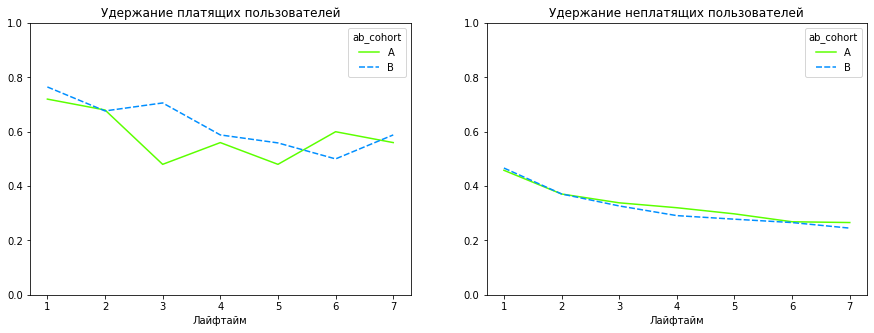

In [96]:
# строим график удержания платящих и неплатящих пользователей в обеих группах

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)

sns.lineplot(
    data=(
        retention_rate.drop(columns=['user_id', 0])
        .query('payer == True')
        .droplevel('payer').T
        ),
    palette='gist_rainbow'
    )

plt.ylim([0, 1])
plt.xlabel('Лайфтайм')
plt.title('Удержание платящих пользователей')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)

sns.lineplot(
    data=(
        retention_rate.drop(columns=['user_id', 0])
        .query('payer == False')
        .droplevel('payer').T),
        palette='gist_rainbow'
        )

plt.xlabel('Лайфтайм')
plt.title('Удержание неплатящих пользователей')

plt.show()

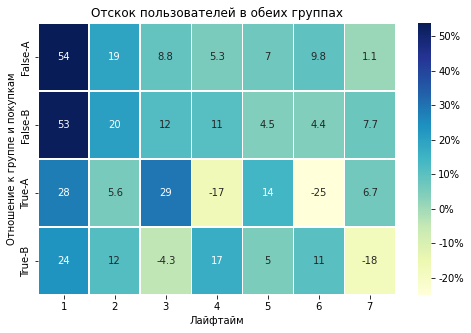

In [97]:
# рассчитываем отскок

churn_rate = cohort_size.join(retention)
churn_rate = churn_rate.div(churn_rate.shift(periods=1, axis=1))
churn_rate = (1 - churn_rate) * 100
churn_rate['user_id'] = cohort_size

# строим тепловую карту

plt.figure(figsize = (8, 5))

sns.heatmap(
    churn_rate.drop(columns=['user_id', 0]),
    cbar_kws={'format': '%.0f%%'},
    annot=True,
    cmap="YlGnBu",
    linewidths=.5
    )

plt.xlabel('Лайфтайм')
plt.ylabel('Отношение к группе и покупкам')
plt.title('Отскок пользователей в обеих группах')

plt.show()


In [98]:
# определим общий процент отскока за 7 дней лайфтайма

common_churn_rate = cohort_size.join(retention[7])

common_churn_rate['percent'] = round(
    (common_churn_rate['user_id'] - common_churn_rate[7])
    / common_churn_rate['user_id'] * 100,
    2)

common_churn_rate

user_id    7  percent
payer ab_cohort                       
False A             3543  942    73.41
      B             3649  895    75.47
True  A               25   14    44.00
      B               34   20    41.18

In [99]:
# находим день лайфтайма, когда была совершена первая покупка, для каждого пользователя;
# формируем таблицу конверсии из неплатящих пользователей в платящие

conversion = (
    (profiles.query('countbuy != 0')
    .sort_values(by=['user_id', 'ab_cohort', 'retention'])
    .groupby(['user_id', 'ab_cohort'])
    .agg({'retention' : 'first'})
    .reset_index())
    .pivot_table(
        index='ab_cohort',
        columns='retention',
        values='user_id',
        aggfunc='nunique'
    ).fillna(0)
)

# преобразовываем таблицу конверсии в таблицу с накоплением

conversion = np.cumsum(conversion, axis=1)

# определяем размер когорт по группам 

cohort_size_group = profiles.pivot_table(
    index='ab_cohort',
    values='user_id',
    aggfunc='nunique')

# находим процент конверсии

conversion = conversion.div(cohort_size_group['user_id'], axis=0)

# добавляем размер когорт

conversion = cohort_size_group.join(conversion)

conversion

,user_id,0,1,2,3,4,5,6,7
ab_cohort,,,,,,,,,
A,3568,0.003083,0.004765,0.005605,0.005886,0.006446,0.006446,0.006726,0.007007
B,3683,0.005159,0.006788,0.007059,0.007602,0.008689,0.008960,0.008960,0.009232


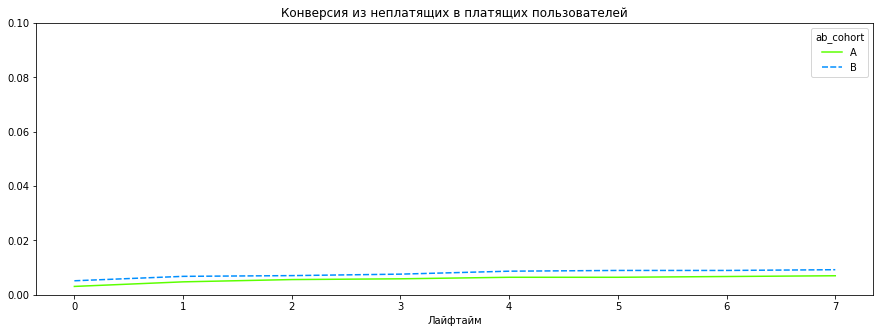

In [100]:
# строим график конверсии

plt.figure(figsize=(15, 5))

sns.lineplot(data=(conversion.drop(columns='user_id').T), palette='gist_rainbow')

plt.ylim([0, .1])
plt.xlabel('Лайфтайм')
plt.title('Конверсия из неплатящих в платящих пользователей')

plt.show()

In [101]:
# находим суммарный доход на каждый день лайфтайма

ltv = profiles.pivot_table(
    index='ab_cohort',
    columns='retention',
    values='sumrevenue',
    aggfunc='sum'
    )

# преобразовываем таблицу ltv в таблицу с накоплением

ltv = np.cumsum(ltv, axis=1)

# находим средний доход от одного пользователя с накоплением

ltv = round(ltv.div(cohort_size_group['user_id'], axis=0), 2)

# добавляем размер когорт

ltv = cohort_size_group.join(ltv)

ltv

,user_id,0,1,2,3,4,5,6,7
ab_cohort,,,,,,,,,
A,3568,0.94,1.22,1.43,1.56,1.83,1.86,2.05,2.28
B,3683,1.78,3.00,3.69,4.68,4.98,5.04,5.82,6.83


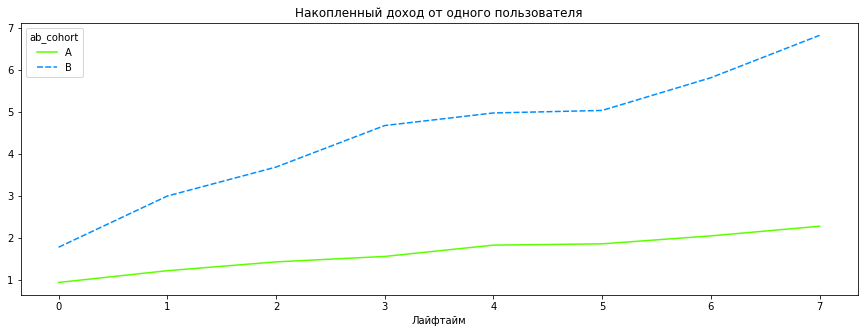

In [102]:
# строим график ltv

plt.figure(figsize=(15, 5))

sns.lineplot(data=(ltv.drop(columns='user_id').T), palette='gist_rainbow')

plt.xlabel('Лайфтайм')
plt.title('Накопленный доход от одного пользователя')

plt.show()

In [103]:
# находим суммарное количество покупок на каждый день лайфтайма

count_buy = profiles.query('payer == True').pivot_table(
    index='ab_cohort',
    columns='retention',
    values='countbuy',
    aggfunc='sum'
    )

# находим размер когорт для платящих пользователей

cohort_size_payers = profiles.query('payer == True').pivot_table(
    index='ab_cohort',
    values='user_id',
    aggfunc='nunique')

# преобразовываем таблицу в таблицу с накоплением

count_buy = np.cumsum(count_buy, axis=1)

# находим средний среднее количество покупок одного пользователя с накоплением

count_buy = round(count_buy.div(cohort_size_payers['user_id'], axis=0), 2)

# добавляем размер когорт

count_buy = cohort_size_payers.join(count_buy)

count_buy

,user_id,0,1,2,3,4,5,6,7
ab_cohort,,,,,,,,,
A,25,1.04,1.32,1.64,1.96,2.24,2.32,2.52,2.76
B,34,0.88,1.44,1.71,2.32,2.62,2.65,2.82,3.03


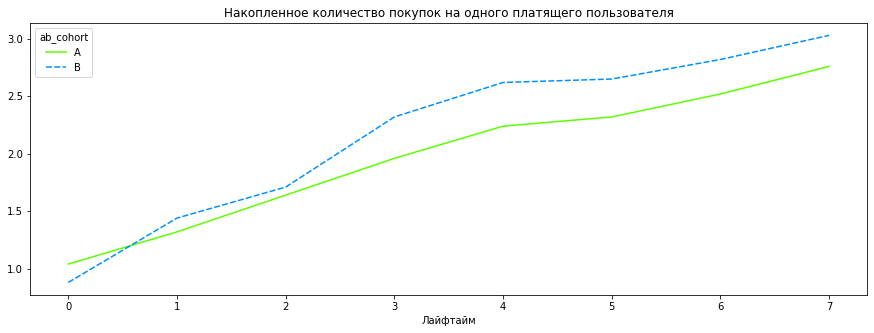

In [104]:
# строим график с накопленным количеством покупок на одного пользователя

plt.figure(figsize=(15, 5))

sns.lineplot(data=(count_buy.drop(columns='user_id').T), palette='gist_rainbow')

plt.xlabel('Лайфтайм')
plt.title('Накопленное количество покупок на одного платящего пользователя')

plt.show()

**Итоги анализа бизнес-показателей:**

Для платящих пользователей цифры могут не отражать реальной картины, поскольку таких пользователей очень мало. К выводам для них следует относиться с осторожностью.

1. Удержание неплатящих пользователей в группах остается примерно на одинаковом уровне в течение всего лайфтайма. В контрольной группе на 7 день заходило 26.5% пользователей, а в тестовой - 24.5%.

2. Удержание платящих пользователей у группы В выше группы А в течение всего лайфтайма, кроме 6 дня. В группе А показатель на 7 день лайфтайма составил 56%, а в группе В - 58.8%.

3. Отскок неплатящих пользователей в обеих группах остается примерно на одинаковом уровне в течение всего лайфтайма. В первый день после установки в приложение не зашло 53% пользователей в группе А и 54% в группе В. Процент отскока на 7 день в контрольной группе составил 73.4%, а в группе В - 75.5%.

4. Сравнить динамику отскока группы А и группы В для платящих пользователей затруднительно. Тепловые карты выглядят как противоположность друг другу. На следующий день после установки в приложение не зашло 28% пользователей в группе А и 24% в группе В. Общий процент отскока в группе А больше, чем в группе В, и равен 44% и 41% соответственно.

5. Конверсия из неплатящих в платящих пользователей у группы В выше, чем у группы А на протяжении всего лайфтайма. При этом за 7 дней пользования в контрольной группе доля платящих пользователей составила 0.7%, а в группе В - 0.9%.

6. Показатель LTV группы В больше группы А на протяжении всего лайфтайма. К 7 дню доход на одного пользователя в контрольной группе составил 2.28 у.е, а в группе В - 6.83 у.е. При известном САС можно было бы определить, окупились ли привлеченные пользователи.

7. Средний платящий пользователь из группы В за 7 дней лайфтайма совершил 3 покупки, а из группы А - 2.7.

## Проверка гипотез

In [105]:
# создаем функцию, которая будет проводить тест манна-уитни
# данный тест выбран как устойчивый к выбросам и малым выборкам

def test(col, data=data, alt='two-sided', alpha = 0.05):

    alpha = alpha

    U, p_value = mannwhitneyu(
        data.query('ab_cohort == "A"')[col],
        data.query('ab_cohort == "B"')[col],
        alternative=alt)

    print('Уровень статистической значимости: ', round(p_value, 5))
            
    if p_value < alpha:
      print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
      print('Не получилось отвергнуть нулевую гипотезу')

Н0: количество пройденных уровней пользователями в группе А и в группе В не отличается.

Н1: количество пройденных уровней пользователями в группе А и в группе В отличается.

In [106]:
# будет совершено 3 теста, поэтому критическое значение уровня значимости будет
# установлено с поправкой Бонферрони

# проверяем, отличается ли количество пройденных уровней пользователями
# в группе А и в группе В
test('maxlevelpassed', data=levels, alpha = 0.05/3)

Уровень статистической значимости:  0.00437
Отвергаем нулевую гипотезу: разница статистически значима


Н0: количество стартов уровней в группе А и в группе В не отличается.

Н1: количество стартов уровней в группе А и в группе В отличается.

In [107]:
# проверяем, отличается ли общее количество стартов уровней
# в группе А и в группе В
test('countallstart', data=levels, alpha = 0.05/3)

Уровень статистической значимости:  0.0
Отвергаем нулевую гипотезу: разница статистически значима


Н0: полученный от пользователей доход в группе А и в группе В не отличается.

Н1: полученный от пользователей доход в группе А и в группе В отличается.

In [108]:
# проверяем, отличается ли полученный от пользователей доход в группе А и в группе В

test(
    'sumrevenue',
     data=(
         profiles
         .groupby(['user_id', 'ab_cohort'])
         .agg({'sumrevenue' : 'sum'})
         .reset_index()),
     alpha = 0.05/3
     )

Уровень статистической значимости:  0.29005
Не получилось отвергнуть нулевую гипотезу


**Итоги проверки гипотез:**

* Разница в количестве пройденных уровней в группе А и в группе В является статистически значимой и составляет 4% (в группе А пользователи максимально доходили до 24 уровня, а в группе В - до 25).

* Разница в количестве стартов уровней в группе А и в группе В является статистически значимой и составляет 13.3% (в группе А - 15 стартов на пользователя, а в группе В - 17).

* Несмотря на то, что к 7 дню доход на одного пользователя в контрольной группе составил 2.28 у.е, а в группе В - 6.83 у.е., тест показал, что она не является статистически значимой.

## Общий вывод

**Прохождение уровней.**

* После предобработки в группе А осталось 3568 пользователей, а в группе В - 3683. Соотношение групп пользователей составляет 49% / 51%, т.е. пользователи распределены равномерно между группами.

* В группе А пользователи максимально доходили до 24 уровня, а в группе В - до 25. Иными словами, в тестовой группе медианное значение на 4% больше относительно контрольной группы. Тест Манна-Уитни показал, что разница статистически значима.

* Доля пользователей, не проходивших ни одного уровня, отличается на 1 процентный пункт: 11.7% в группе А и 10.6% в группе В.

Таким образом, уменьшение времени восстановления жизни способствует увеличению количества прохождений уровней как удачных, так и неудачных.

**Обращение золота.**

Было отмечено следующее:
* уменьшение доли пользователей, не прошедших ни одной главы, на 3.5 процентных пункта, что связано с увеличением количества проходимых уровней;
* уменьшение доли пользователей, отправляющих жизни в команду, на 2 процентных пункта;
* уменьшение доли пользователей, приобретающих жизни, на 3 процентных пункта;
* увеличение доли пользователей, приобретающих дополнительный ход, на 2.8 процентных пункта.

Уменьшение времени восстановления жизни с 30 до 3 минут не повлияло на медианные показатели, связанные с обращением золота, в частности, на получение золота из покупки и за регистрацию в Facebook.

**Бизнес-показатели.**

* Удержание неплатящих пользователей в группах остается примерно на одинаковом уровне в течение всего лайфтайма. В контрольной группе на 7 день заходило 26.5% пользователей, а в тестовой - 24.5%.

* Отскок неплатящих пользователей в обеих группах остается примерно на одинаковом уровне в течение всего лайфтайма. В первый день после установки в приложение не зашло 53% пользователей в группе А и 54% в группе В. Процент отскока на 7 день в контрольной группе составил 73.4%, а в группе В - 75.5%.

* Удержание платящих пользователей у группы В выше группы А в течение всего лайфтайма, кроме 6 дня. В группе А показатель на 7 день лайфтайма составил 56%, а в группе В - 58.8%.

* На следующий день после установки в приложение не зашло 28% пользователей в группе А и 24% в группе В. Общий процент отскока в группе А больше, чем в группе В, и равен 44% и 41% соответственно.

* Конверсия из неплатящих в платящих пользователей у группы В выше, чем у группы А на протяжении всего лайфтайма. При этом за 7 дней пользования в контрольной группе доля платящих пользователей составила 0.7%, а в группе В - 0.9%.

* Средний платящий пользователь из группы В за 7 дней лайфтайма совершил 3 покупки, а из группы А - 2.7.

* Показатель LTV группы В больше группы А на протяжении всего лайфтайма. К 7 дню доход на одного пользователя в контрольной группе составил 2.28 у.е, а в группе В - 6.83 у.е. При известном САС можно было бы определить, окупились ли привлеченные пользователи. В то же время тест Манна-Уитни показал, то разница не является статистически значимой.

**Итог и рекомендации.**

Уменьшение времени восстановления жизни с 30 до 3 минут положительно повлияло на пользователей, но не факт, что влияние на получение прибыли такое же.

В тестовой группе отмечается увеличение количества пользователей, которые прошли хотя бы один уровень, и увеличение количества пройденных уровней в целом. При этом отскок и удержание среди неплатящих пользователей в группе В показывает результаты немного хуже, чем в группе А.

Показатели удержания и отскока платящих пользователей в тестовой группе лучше, чем в контрольной. В группе В конверсия в платящих пользователей лучше, отмечается большее количество покупок на пользователя и больший доход. Из-за того, что платящие пользователи составляют менее процента от всего количества, нельзя утверждать, что данные изменения отражают реальную картину. К тому же, несмотря на отличие в доходах от одного пользователя в 3 раза, тест Манна-Уитни показал, то разница не является статистически значимой.

Если учесть, что основной доход игры - это показ рекламы, то можно предположить, что увеличение медианного количества попыток прохождения уровней на 13.3% увеличивает доход с показа рекламы, т.к. она демонстрируется после прохождения каждого уровня.

В то же время количество полученного золота за просмотр рекламы не изменилось, как и не изменилась доля пользователей, которая этим воспользовалась.

Таким образом, если доход с показа рекламы пользователям в указанный период для данных пользователей увеличился, то А/В-тест можно считать удачным. В противном случае, таким его назвать нельзя.

Чтобы избежать подобной неоднозначность, следует заранее определить метрики и их ожидаемые изменения, по которым А/В-тест будет считаться удачным, и исходя из этого определять размер групп и набор данных для анализа. Также отдельно стоит обращаться внимание на платящих пользователей. Возможно, стоит увеличить выборку и время проведения теста, чтобы увеличить количество платящих пользователей, принимающих участие в нем. Это будет способствовать получению более точных результатов согласно закону больших чисел.
